# Detecting Sarcasm in Text
### Calvin Choi

The purpose of this project to the develop a model that can accurately discern sarcastic comments when provided the raw text. The process includes parsing the text, engineering informative features and applying text preprocessing before using classification algorithms to classify the text.

The data used in this study includes a pre-labelled dataset downloaded from Kaggle. As per the author, the dataset contains sarcastic and non-sarcastic comments, labelled as 1 and 0 respectively, that was scraped from Reddit. To accurately identify sarcasm in the comments, the author relied on the Reddit-specific tag /s which users typically utilize to designate sarcasm in their comment. The dataset includes 1,010,774 comments and attributes related to each comment, such as the number of likes, the date it was made, the parent comment, etc. In addition, the original dataset includes a perfect class balance between sarcastic and non-sarcastic comments.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
reddit = pd.read_csv('train-balanced-sarcasm.csv')

In [3]:
reddit.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


## 1. EDA

Exploratory data analysis (EDA) will be conducted on the data to derive insight. The insight gained from this section will be used to drive feature engineering.  

In [4]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [5]:
reddit['label'].value_counts()

1    505413
0    505413
Name: label, dtype: int64

The above numbers indicate that there is a perfect ratio of sarcastic to non-sarcastic comments in this dataset. As this is extremely rare in a real-world scenerio, it should be noted that the data presented at this point is simply what the authors of the data had provided.

In [6]:
reddit.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

There are 53 instances with null values under the comment feature, which will be removed from the dataset.

In [4]:
# Remove all rows is NA 
reddit = reddit[reddit['comment'].notna()]

**Analyzing n-grams of Sarcastic Comments**

Here bigrams and trigrams are extracted from the comment feature to gain understanding into what the most common two and three word combinations are with respect to sarcastic comments. This analysis also determines the feasibility of introducing a bag of ngrams as the input for the classification model, rather than a collection of unigrams.

In [5]:
# First remove stop words in the comments
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [6]:
reddit['comment_without_stopwords'] = reddit['comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [7]:
# Create function to find ngrams in 'comment' column 
def ngrams(comments, n):
    return list(zip(*[comments[i:] for i in range(n)]))

# Create dataframe with all bigrams and trigrams
df_ngrams = pd.DataFrame()
df_ngrams['bigrams'] = reddit[reddit['label']==1]['comment_without_stopwords'].map(lambda x: ngrams(x.split(" "), 2))
df_ngrams['trigrams'] = reddit[reddit['label']==1]['comment_without_stopwords'].map(lambda x: ngrams(x.split(" "), 3))
df_ngrams.head()

,bigrams,trigrams
33,"[(But, they'll), (they'll, reviews!)]","[(But, they'll, reviews!)]"
44,"[(wow, totally), (totally, unreasonable), (unr...","[(wow, totally, unreasonable), (totally, unrea..."
45,"[(Ho, ho), (ho, ho...), (ho..., But), (But, Me...","[(Ho, ho, ho...), (ho, ho..., But), (ho..., Bu..."
66,"[(I, can't), (can't, wait), (wait, @potus), (@...","[(I, can't, wait), (can't, wait, @potus), (wai..."
69,"[(gotta, love), (love, teachers), (teachers, g...","[(gotta, love, teachers), (love, teachers, giv..."


In [8]:
from collections import Counter
from itertools import chain

In [9]:
# Generate list of top 10 bigrams in the sarcastic class, and count number of comments that contain each bigram 
bigrams = df_ngrams['bigrams'].tolist()
bigrams = list(chain(*bigrams))
bigrams = [(x.lower(), y.lower()) for x,y in bigrams]

top10_bigrams = Counter(bigrams).most_common(10)
top10_bigrams

[(("i'm", 'sure'), 5180),
 (('i', 'think'), 4991),
 (('i', 'thought'), 2936),
 (('you', 'forgot'), 2819),
 (('i', 'know'), 2449),
 (('i', 'guess'), 2281),
 (('sounds', 'like'), 1959),
 (('i', "can't"), 1804),
 (('i', 'see'), 1593),
 (('good', 'thing'), 1566)]

In [10]:
# Generate list of top 10 trigrams in the sarcastic class, and count number of comments that contain each trigram 
trigrams = df_ngrams['trigrams'].tolist()
trigrams = list(chain(*trigrams))
trigrams = [(x.lower(), y.lower(), z.lower()) for x,y,z in trigrams]

top10_trigrams = Counter(trigrams).most_common(10)
top10_trigrams

[(('but', 'i', 'thought'), 534),
 (("i'm", 'pretty', 'sure'), 449),
 (('i', 'think', 'forgot'), 434),
 (('i', "can't", 'wait'), 423),
 (('you', 'dropped', 'this:'), 344),
 (('i', 'think', 'dropped'), 318),
 (('i', 'guess', 'i'), 317),
 (('yeah,', "i'm", 'sure'), 312),
 (('i', "can't", 'believe'), 310),
 (('you', 'sound', 'like'), 236)]

The most common bigram associated with sarcastic comments is "i'm sure" with 5,180 comments containing this bigram. The most common trigram is "but i thought" with 534 comments containing this bigram. Other bigrams and trigrams presented above are not uncommon with sarcastic phrases. 

**Comparing Comment Length in Sarcastic and Non-Sarcastic Comments**

Next, the length of each commennt will be analyzed to observe any difference between sarcastic and non-sarcastic comments.

In [11]:
# Create new feature that count the number of words in each comment 
reddit['comment length'] = reddit['comment'].str.split().str.len()

(0, 100)

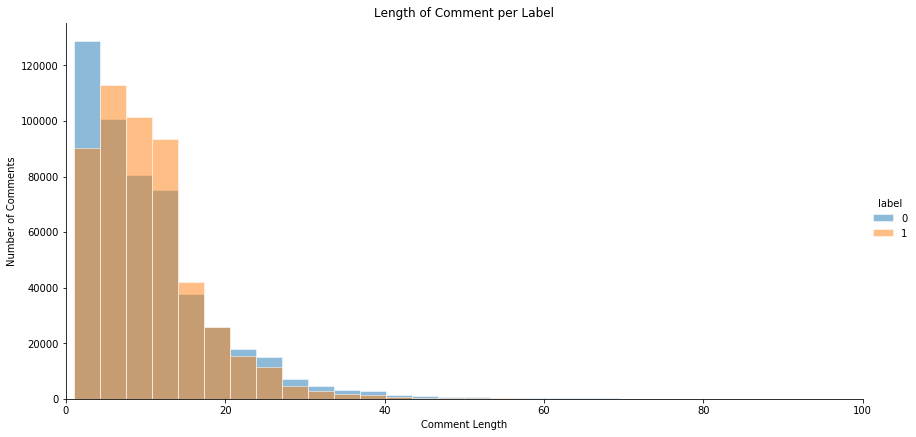

In [18]:
# Barplot showing distribution of number of comments at each comment length from 0 to 100 words 
g = sns.FacetGrid(reddit[reddit['comment length']<100], hue="label", height=6, aspect=2)
g = g.map(plt.hist, 'comment length', bins=30, alpha=0.5, ec='white').add_legend()
plt.title("Length of Comment per Label")
ylabel = plt.ylabel("Number of Comments")
xlabel = plt.xlabel("Comment Length")
plt.xlim(0,100)

The above bar plot present the distribution of the number of comments at each comment length, from 0 to 100 words, for sarcastic to non-sarcastic comments.

**Comparing Punctuation Marks in Sarcastic vs Non-sarcastic Comments**

In [361]:
# Create new feature that counts the number of ellipsis in each comment
reddit['# of ellipsis'] = reddit['comment'].apply(lambda x : x.count('...'))
reddit['# of exclamations'] = reddit['comment'].apply(lambda x : x.count('!'))
reddit['# of question marks'] = reddit['comment'].apply(lambda x : x.count('?'))
reddit['# of quotation marks'] = reddit['comment'].apply(lambda x : x.count('"'))

In [ ]:
def get_table(x):
    num_sarcastic  = []
    num_nonsarcastic = []
    for i in range(1,5):
        num_sarcastic.append(len(reddit[(x==i)&(reddit['label']==1)]))
        num_nonsarcastic.append(len(reddit[(x==i)&(reddit['label']==0)]))
    
    table = pd.DataFrame()
    table['# of Sarcastic Comments'] = num_sarcastic
    table['# of Non-Sarcastic Comments'] = num_nonsarcastic
    table['Proportion of Sarcastic Comment'] = table.iloc[:,0]/(table.iloc[:,0]+table.iloc[:,1])
    table.index.names = [x.name+' in comment']
    table.index += 1
    return(table)

**Ellipsis**

Sarcasm in text may differentiate from non-sarcastic text in the number and types of punctuations used. First, the number of ellipses (...) in each comment will be calculated. Then the differences between sarcastic and non-sarcastic comments based on these counts will be analyzed for insight. 

In [383]:
ellipsis_table = get_table(reddit['# of ellipsis'])
ellipsis_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of ellipsis in comment,,,
1,32150,29951,0.5177
2,3732,3039,0.5512
3,648,524,0.5529
4,175,134,0.5663


The above table show that as the number of ellipsis in a comment increases, the porportion of sarcastic to non-sarcastic comments also increase. Below are pie charts illustrating the same point in a visual manner.

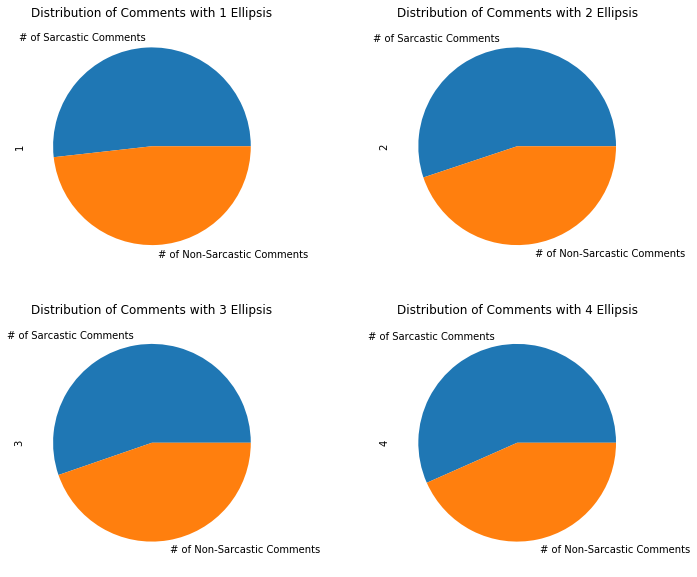

In [22]:
# Remove last column and transpose above table.
ellipsis_pie = ellipsis_table[ellipsis_table.columns[:-1]].transpose()

# Plot pie chart for each distribution of comments, from 1 to 4 ellipsis.
cols = range(1,5)
fig, ax = plt.subplots(2,2, figsize=(12, 10))
for i, axis in enumerate(ax.flatten()):    
    ellipsis_pie.plot(kind='pie', y=cols[i], legend=False, title='Distribution of Comments with %s Ellipsis' %(cols[i]), ax=axis)

**Exclamations**

In [397]:
excalmation_table = get_table(reddit['# of exclamations'])
excalmation_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of exclamations in comment,,,
1,68788,27658,0.7132
2,128,72,0.6400
3,73,51,0.5887
4,27,19,0.5870


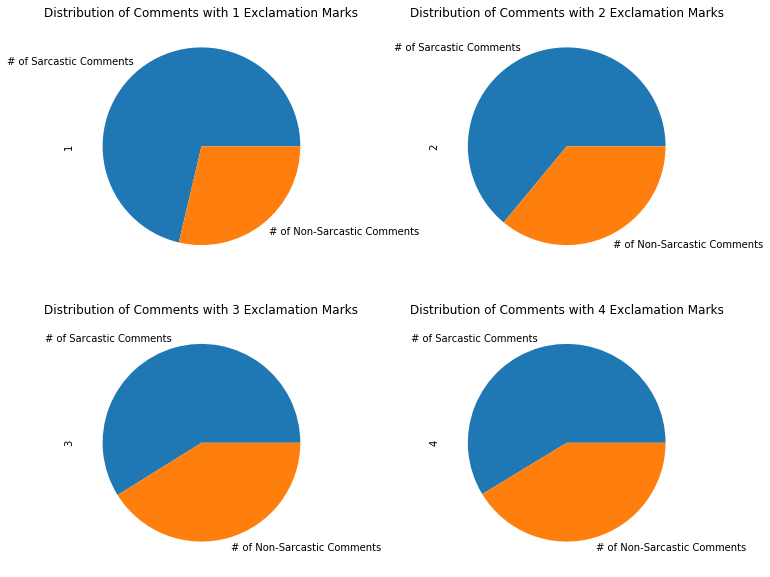

In [400]:
# Remove last column and transpose above table.
excalmation_pie = excalmation_table[excalmation_table.columns[:-1]].transpose()

# Plot pie chart for each distribution of comments, from 1 to 4 exclamation marks.
cols = range(1,5)
fig, ax = plt.subplots(2,2, figsize=(12, 10))
for i, axis in enumerate(ax.flatten()):    
    excalmation_pie.plot(kind='pie', y=cols[i], legend=False, title='Distribution of Comments with %s Exclamation Marks' %(cols[i]), ax=axis)

In [401]:
question_table = get_table(reddit['# of question marks'])
question_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of question marks in comment,,,
1,54955,62766,0.4668
2,37,48,0.4353
3,16,21,0.4324
4,7,4,0.6364


In [399]:
quotation_table = get_table(reddit['# of quotation marks'])
quotation_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of quotation marks in comment,,,
1,215,320,0.4019
2,14418,20522,0.4127
3,24,33,0.4211
4,924,1633,0.3614


**Laughing and Smiley Face**

In [405]:
# Count the number of (case insensitive) "haha", "lol", and smiley face emoticons in each comment
reddit['haha_count'] = reddit['comment'].apply(lambda x : x.upper().count('haha'.upper()))
reddit['lol_count'] = reddit['comment'].apply(lambda x : x.upper().count('lol'.upper()))
reddit['smiley_face_count'] = reddit['comment'].apply(lambda x : x.count(':)'))

In [430]:
df_laughing = pd.DataFrame()

for each in reddit.columns[-3:]:
    df_laughing[each] = reddit[reddit[each]>0].groupby(pos_df['label'])['comment'].count()

df_laughing = df_laughing.transpose()
df_laughing.columns = ['non_sarcastic', 'sarcastic']
df_laughing

,non_sarcastic,sarcastic
haha_count,2475,1735
lol_count,5824,3138
smiley_face_count,3232,509


**Counting Consecutive Characters**

In this section, the number of repeating consecutive characters in a word within a comment will be analyzed for any difference in sarcasm and non-sarcasm. For example, consider the following comment from the dataset:

*"Oooo you're so edgy putting that here."*

Here, the count of repeating consectutive characters is 4. If a comment contains two words with repeating consecutive characters, only the word with the highest number will be observed. 

In [13]:
# Define function to count the number of characters that repeat the most. 
import re

def consecutive_repeating_chars(x):
    repeating_chars = [match[0] for match in re.findall(r'((\w)\2{2,})', x)]
    if not repeating_chars:
        return 0
    else:
        repeating_chars = " ".join(repeating_chars)
        max_repeated = max([len(word) for word in repeating_chars.split()])
        return(max_repeated)

In [14]:
# Apply function to comments and create new feature with the counts
reddit['num_repeated_chars'] = reddit['comment'].apply(lambda x : consecutive_repeating_chars(x))

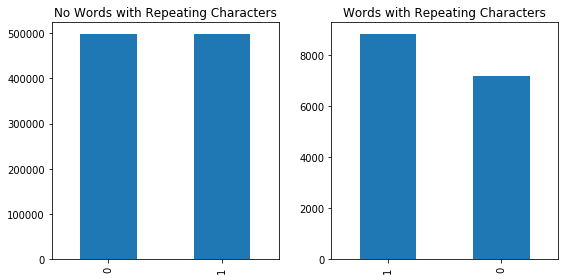

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2)
reddit[reddit['num_repeated_chars']==0]['label'].value_counts().plot(kind='bar', figsize=(8,4), ax=axes[0], title='No Words with Repeating Characters')
reddit[reddit['num_repeated_chars']>=1]['label'].value_counts().plot(kind='bar', figsize=(8,4), ax=axes[1], title='Words with Repeating Characters')
plt.tight_layout()

The left barplot presents the distribution of sarcastic and non-sarcastic comments containing words with no repeating characters, while the plot on the right show the distribution for comments containing at least one word with repeating characters. It can be observed that less than 2% of comments in the dataset contain repeating characters, while the vast majority of comments do not.

In [28]:
# For comments that contain 1-4 ellipsis, count the number of sarcastic vs. non-sarcastic comments
num_sarcastic  = []
num_nonsarcastic = []
for i in range (3,11):
    num_sarcastic.append(len(reddit[(reddit['num_repeated_chars']==i)&(reddit['label']==1)]))
    num_nonsarcastic.append(len(reddit[(reddit['num_repeated_chars']==i)&(reddit['label']==0)]))

# Create df that contain above info and the proportion of sarcastic to non-sarcastic comments
rep_table = pd.DataFrame()
rep_table['# of Sarcastic Comments'] = num_sarcastic
rep_table['# of Non-Sarcastic Comments'] = num_nonsarcastic
rep_table['Proportion of Sarcastic Comment'] = rep_table.iloc[:,0]/(rep_table.iloc[:,0]+rep_table.iloc[:,1])
rep_table.index.names = ['# of repeated characters']
rep_table.index += 3
rep_table

,# of Sarcastic Comments,# of Non-Sarcastic Comments,Proportion of Sarcastic Comment
# of repeated characters,,,
3,4407,3406,0.5641
4,1753,1221,0.5894
5,982,794,0.5529
6,558,454,0.5514
7,323,298,0.5201
8,198,205,0.4913
9,133,126,0.5135
10,85,97,0.4670


The above table shows the proportion of sarcastic to non-sarcastic comments as the number of repeating characters increase from 1 to 10. Sarcastic comments appear to have the largest proportion of comments at four repeating characters, with 59% of those comments being sarcastic. As the number increases, so does the proportion of sarcastic comments.

**Parts of Speech Tagging (POS) and Named Entity Recognition (NER)**

In [16]:
# Load spacy and English dictionary
import spacy
nlp = spacy.load('en_core_web_sm')

In [17]:
# Create spacy DOC object
df = pd.DataFrame()
reddit['nlp'] = [doc for doc in nlp.pipe(reddit['comment'].tolist())]

In [43]:
# Create columns containing POS and NER tags for each comment
pos = []
ner = []

for doc in reddit['nlp']:  
    if doc.is_parsed:
        pos.append([n.pos_ for n in doc])
        ner.append([n.label_ for n in doc.ents])
    else:
        pos.append(None)
        ner.append(None)

reddit['pos_tags'] = pos
reddit['ner_tags'] = ner

In [113]:
reddit.head(1)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_without_stopwords,comment length,# of ellipsis,num_repeated_chars,nlp,pos_tags,ner_tags
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",NC NH.,3,0,0,"(NC, and, NH, .)","[PROPN, CCONJ, PROPN, PUNCT]","[GPE, GPE]"


**Parts of Speech Tagging**

In [186]:
import itertools
import collections

In [238]:
import itertools
pos_list = list(set([*itertools.chain.from_iterable(reddit['pos_tags'])]))
pos_list.remove('SPACE')
print(pos_list)

['X', 'DET', 'VERB', 'NOUN', 'INTJ', 'ADP', 'AUX', 'PART', 'SPACE', 'CCONJ', 'PRON', 'SCONJ', 'SYM', 'ADJ', 'PROPN', 'ADV', 'PUNCT', 'NUM']


In [188]:
pos_nonsarcastic = [*itertools.chain.from_iterable(reddit[reddit['label']==1]['pos_tags'])]
pos_sarcastic = [*itertools.chain.from_iterable(reddit[reddit['label']==0]['pos_tags'])]

pos_nonsarcastic_count = collections.Counter(pos_nonsarcastic)
pos_sarcastic_count = collections.Counter(pos_sarcastic)

In [226]:
df_nonsarcastic = pd.DataFrame.from_dict(pos_nonsarcastic_count, orient='index')

df_sarcastic = pd.DataFrame.from_dict(pos_sarcastic_count, orient='index')

pos_count_df = pd.concat([df_nonsarcastic, df_sarcastic], axis=1).fillna(0)
pos_count_df.columns = ['non_sarcastic', 'sarcastic']
pos_count_df.iloc[:,0] = pos_count_df.iloc[:,0].astype('Int64')
pos_count_df['difference'] = (pos_count_df['non_sarcastic'] - pos_count_df['sarcastic']).abs()
pos_count_df.sort_values(by=['difference'], ascending=False)

,non_sarcastic,sarcastic,difference
PUNCT,666819,723463,56644
INTJ,118585,63024,55561
ADP,377968,432211,54243
PROPN,341668,387184,45516
ADJ,410561,381936,28625
NOUN,921078,947193,26115
PRON,525738,551155,25417
NUM,61503,84055,22552
DET,593632,609617,15985
AUX,438014,429179,8835


In [292]:
pos_df = reddit[['label', 'pos_tags']].copy()

for each in pos_list:
    pos_df[each+' Ratio'] = pos_df['pos_tags'].apply(lambda x: (x.count(each)/len(x)))

In [293]:
pos_df.iloc[[1]]

,label,pos_tags,X Ratio,DET Ratio,VERB Ratio,NOUN Ratio,INTJ Ratio,ADP Ratio,AUX Ratio,PART Ratio,SPACE Ratio,CCONJ Ratio,PRON Ratio,SCONJ Ratio,SYM Ratio,ADJ Ratio,PROPN Ratio,ADV Ratio,PUNCT Ratio,NUM Ratio
1,0,"[PRON, AUX, VERB, NOUN, NOUN, VERB, ADP, PROPN...",0.0000,0.0000,0.1333,0.2667,0.0000,0.0667,0.0667,0.0000,0.0000,0.0000,0.0667,0.0667,0.0000,0.1333,0.0667,0.0667,0.0667,0.0000


In [256]:
cols = list(pos_df)
cols.remove('label')

pos_mean = pos_df[cols].groupby(pos_df['label']).mean().transpose()
pos_mean.columns = ['Non-sarcastic', 'Sarcastic']
pos_mean['difference'] = (pos_mean['Non-sarcastic'] - pos_mean['Sarcastic']).abs()
pos_mean.sort_values(by=['difference'], ascending=False)

,Non-sarcastic,Sarcastic,difference
PUNCT Ratio,0.1366,0.1178,0.0188
PROPN Ratio,0.0890,0.0732,0.0158
VERB Ratio,0.1133,0.1232,0.0098
ADJ Ratio,0.0624,0.0693,0.0069
DET Ratio,0.0867,0.0934,0.0067
AUX Ratio,0.0625,0.0685,0.0060
NUM Ratio,0.0141,0.0098,0.0043
ADP Ratio,0.0559,0.0518,0.0041
SCONJ Ratio,0.0168,0.0201,0.0034
PART Ratio,0.0259,0.0293,0.0033


**Named Entity Recognition**

In [261]:
# Get list of all NER tags in dataframe 
ner_list = list(set([*itertools.chain.from_iterable(reddit['ner_tags'])]))
print(ner_list)

['EVENT', 'WORK_OF_ART', 'LOC', 'PERCENT', 'PRODUCT', 'ORDINAL', 'MONEY', 'LAW', 'DATE', 'QUANTITY', 'TIME', 'LANGUAGE', 'GPE', 'NORP', 'PERSON', 'FAC', 'CARDINAL', 'ORG']


In [262]:
ner_df = reddit[['label', 'ner_tags']].copy()
ner_df.head()

,label,ner_tags
0,0,"[GPE, GPE]"
1,0,[]
2,0,"[TIME, PERSON, TIME, GPE]"
3,0,[GPE]
4,0,[]


In [264]:
ner_nonsarcastic = [*itertools.chain.from_iterable(reddit[reddit['label']==1]['ner_tags'])]
ner_sarcastic = [*itertools.chain.from_iterable(reddit[reddit['label']==0]['ner_tags'])]

ner_nonsarcastic_count = collections.Counter(ner_nonsarcastic)
ner_sarcastic_count = collections.Counter(ner_sarcastic)

In [266]:
df_nonsarcastic_ner = pd.DataFrame.from_dict(ner_nonsarcastic_count, orient='index')

df_sarcastic_ner = pd.DataFrame.from_dict(ner_sarcastic_count, orient='index')

ner_count_df = pd.concat([df_nonsarcastic_ner, df_sarcastic_ner], axis=1).fillna(0)
ner_count_df.columns = ['non_sarcastic', 'sarcastic']
ner_count_df.iloc[:,0] = ner_count_df.iloc[:,0].astype('Int64')
ner_count_df['difference'] = (ner_count_df['non_sarcastic'] - ner_count_df['sarcastic']).abs()
ner_count_df.sort_values(by=['difference'], ascending=False)

,non_sarcastic,sarcastic,difference
CARDINAL,33241,43136,9895
DATE,21067,29369,8302
NORP,21704,14424,7280
ORG,59666,64095,4429
PERSON,55829,60209,4380
ORDINAL,5779,8374,2595
TIME,3706,6079,2373
WORK_OF_ART,2911,4123,1212
PRODUCT,2943,4130,1187
FAC,1123,1508,385


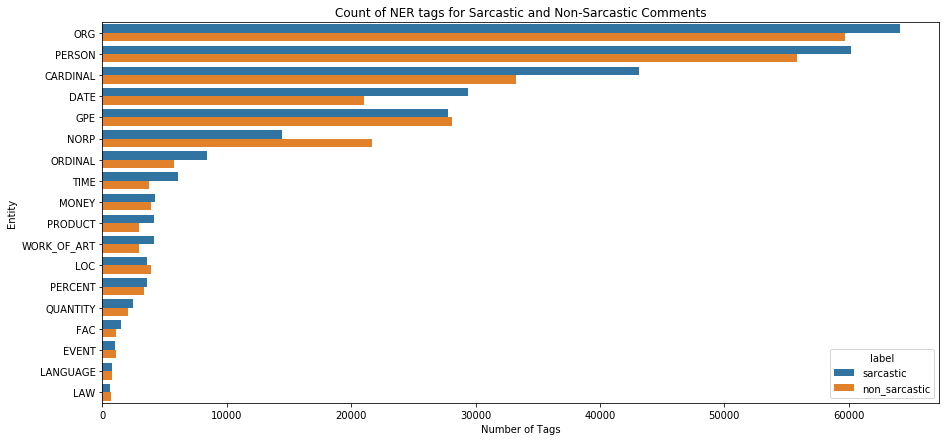

In [321]:
# Melt df_count_df
ner_count_melt = pd.melt(ner_count_df.reset_index(), id_vars='index', value_vars=['non_sarcastic','sarcastic'], var_name='label')
ner_count_melt = ner_count_melt.sort_values(by=['value'], ascending=False)

# Plot horizontal barplot
fig,ax = plt.subplots(figsize=(15, 7))
sns.barplot(x='value', y='index', hue='label', data=ner_count_melt)
plt.title('Count of NER tags for Sarcastic and Non-Sarcastic Comments')
plt.xlabel('Number of Tags')
plt.ylabel('Entity');

In [273]:
# Create dataframe to count tags in each column
ner_df = reddit[['label', 'ner_tags']].copy()

for each in ner_list:
    ner_df[each+' count'] = ner_df['ner_tags'].apply(lambda x: len([ent for ent in x if ent == each]))

In [327]:
ner_df.head()

,label,ner_tags,EVENT count,WORK_OF_ART count,LOC count,PERCENT count,PRODUCT count,ORDINAL count,MONEY count,LAW count,DATE count,QUANTITY count,TIME count,LANGUAGE count,GPE count,NORP count,PERSON count,FAC count,CARDINAL count,ORG count
0,0,"[GPE, GPE]",0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,"[TIME, PERSON, TIME, GPE]",0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0
3,0,[GPE],0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
